In [53]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from hnlp_proj.loader import load_ynet, load_eng_test
from hnlp_proj.utils import extract_authors, flip_hebrew_text, combine_texts, clean_texts
from hnlp_proj.plot_utils import plot_hebrew_barchart, plot_corpus_sizes


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
#texts = load_ynet()
texts = load_eng_test()
#texts

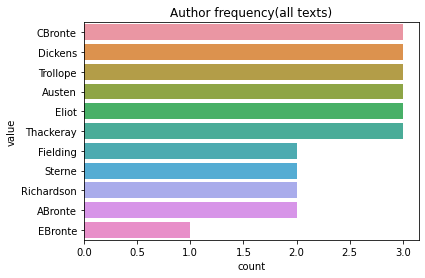

In [73]:
# Plotting frequency of categories
if "category" in texts.columns:
    plot_hebrew_barchart(texts.category, 20, title="Text categories")

# Plotting author frequency of texts
NUM_AUTHORS = 20
texts.authors = texts.authors.apply(extract_authors)
plot_hebrew_barchart(texts.authors, NUM_AUTHORS, title="Author frequency(all texts)")

# find all texts that only have 1 author
one_author_df = texts[texts.authors.str.len() == 1].copy()
one_author_df["authors"]  = one_author_df["authors"].apply(lambda ls: ls[0])
one_author_df.rename(columns={"authors": "author"}, inplace=True)

if len(one_author_df) != len(texts):
    plot_hebrew_barchart(one_author_df.author, NUM_AUTHORS, title="Author frequency(texts with only 1 author)")

In [15]:
print(f"Out of {len(texts)} articles, {len(one_author_df)} of them were written by exactly 1 author")

Out of 9 articles, 9 of them were written by exactly 1 author


In [69]:
# find texts with no author(Faulty parsing?)
no_author_df = texts[texts.authors.str.len() == 0]
no_author_df

,authors,title,text


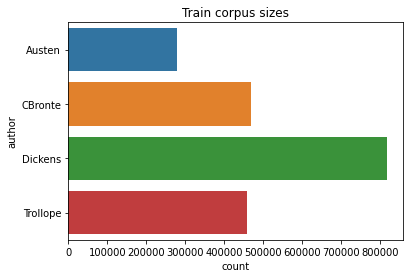

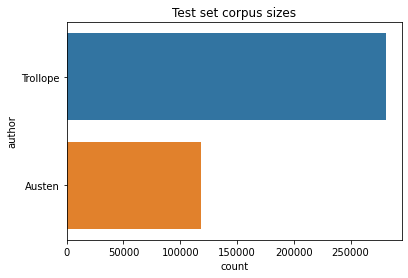

Accuracy: 0.5
Balanced Accuracy: 0.5
/home/nmdanny/hnlp_proj/hnlp_proj/delta.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["count"] = df["text"].str.split().str.len() + 1
/home/nmdanny/.cache/pypoetry/virtualenvs/hnlp-proj-TiVffxGf-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.5

In [81]:
from hnlp_proj.delta import create_feature_matrix, add_count_column, combine_texts_by_author
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import f1_score, auc, accuracy_score, balanced_accuracy_score

RANDOM_STATE = 0
NUM_AUTHORS = 4
NUM_FEATURES = 25

# choose some of the most prolific authors
most_prolific_authors = one_author_df.author.value_counts()[:NUM_AUTHORS].index
used_texts = one_author_df.set_index("author").loc[most_prolific_authors].reset_index()

# split one-author dataset to train and test
X_train, X_test = train_test_split(used_texts, random_state=RANDOM_STATE,
 test_size=0.1)

plot_corpus_sizes(combine_texts_by_author(X_train), title="Train corpus sizes")
plot_corpus_sizes(X_test.set_index("author"), "Test set corpus sizes")


X_train = create_feature_matrix(X_train, num_features=NUM_FEATURES)
X_test = create_feature_matrix(X_test, features=X_train.columns, combine_by_author=False)
#X_train.dropna(inplace=True)
y_train = X_train.index
y_test = X_test.index


knn = KNeighborsClassifier(n_neighbors=1, metric="manhattan")
knn.fit(X_train, y_train)

#print(f"Score using features: {set(X_train.columns)}")

y_pred = knn.predict(X_test)

#print(f"F1 score: {f1_score(y_test, y_pred, labels=most_prolific_authors, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
knn.score(X_test, y_test)

In [77]:
from hnlp_proj.delta import create_feature_matrix, add_count_column, combine_texts_by_author
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, auc, accuracy_score, balanced_accuracy_score

NUM_AUTHORS = 4
NUM_FEATURES = 25

# choose some of the most prolific authors
most_prolific_authors = one_author_df.author.value_counts()[:NUM_AUTHORS].index
used_texts = one_author_df.set_index("author").loc[most_prolific_authors].reset_index()

loo = LeaveOneOut(used_texts)

for X_train, X_test in loo:
    #plot_corpus_sizes(combine_texts_by_author(X_train), title="Train corpus sizes")
    #plot_corpus_sizes(X_test, "Test set corpus sizes")


    X_train = create_feature_matrix(X_train, num_features=NUM_FEATURES)
    X_test = create_feature_matrix(X_test, features=X_train.columns, combine_by_author=False)
    #X_train.dropna(inplace=True)
    y_train = X_train.index
    y_test = X_test.index


    knn = KNeighborsClassifier(n_neighbors=1, metric="manhattan")
    knn.fit(X_train, y_train)

#print(f"Score using features: {set(X_train.columns)}")

    y_pred = knn.predict(X_test)

    #print(f"F1 score: {f1_score(y_test, y_pred, labels=most_prolific_authors, average='weighted')}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    knn.score(X_test, y_test)

TypeError: LeaveOneOut() takes no arguments